In [ ]:
!unzip ears.zip

In [2]:
import cv2
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from sklearn import model_selection
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [49]:
# global variables

INPUT_SHAPE_X = 128
INPUT_SHAPE_Y = 64
ITERATION = '4'
EPOCHS = 1000
BATCH_SIZE = 4

max_images = 3600 # max images per class

In [37]:
# load labels
csv_path = 'labels_preprocessed.csv'
labels = pd.read_csv(csv_path)
# replace NaN values with 0s
labels.fillna(0, inplace=True)

In [ ]:
# load the images
ears_path = 'ears'
ears_dir = os.listdir(ears_path)
x_ears = []
y_ears = []
i = 0
class_0 = 0
class_1 = 0
class_2 = 0

# iterate over images
for image in ears_dir:
    # load the image
    image_path = os.path.join(ears_path, image)
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(INPUT_SHAPE_X, INPUT_SHAPE_Y))
    img = tf.keras.preprocessing.image.img_to_array(img)
    
    # preprocess the image
    if (img is not None):
    
        # check image class
        image_class = labels.loc[labels['imageid'] == image, 'ear_position']

        if not image_class.empty:
            image_class = image_class.iloc[0]    
            
            # append an equal number of images from each class
            if (image_class == 0.0 and class_0 < max_images):
                x_ears.append(img)
                y_ears.append(image_class)
                class_0 += 1
                if (i == max_images*3):
                    break
                i+=1
                
                
            elif (image_class == 1.0 and class_1 < max_images):
                x_ears.append(img)
                y_ears.append(image_class)
                class_1 += 1
                if (i == max_images*3):
                    break
                i+=1
                
                
            elif (image_class == 2.0 and class_2 < max_images):
                x_ears.append(img)
                y_ears.append(image_class)
                class_2 += 1
                if (i == max_images*3):
                    break
                i+=1
  


In [39]:
# add flipped images from class 2
flipped_path = 'ears-flipped'
for image in os.listdir(flipped_path):
    image_path = os.path.join(flipped_path, image)
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(INPUT_SHAPE_X, INPUT_SHAPE_Y))
    img = tf.keras.preprocessing.image.img_to_array(img)
    x_ears.append(img)
    y_ears.append(2)
    class_2 += 1

In [40]:
# add augmented images from class 2
aug_path = 'ears-augmented'
for image in os.listdir(aug_path):
    image_path = os.path.join(aug_path, image)
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(INPUT_SHAPE_X, INPUT_SHAPE_Y))
    img = tf.keras.preprocessing.image.img_to_array(img)
    x_ears.append(img)
    y_ears.append(2)
    class_2 += 1

In [42]:
print(class_0, class_1, class_2)

3800 3160 3041


In [43]:
# preprocess
x_ears = tf.keras.applications.vgg16.preprocess_input(np.array(x_ears))

# split the dataset into train and test sets
x_train_val, x_test, y_train_val, y_test = model_selection.train_test_split(
    x_ears, y_ears, test_size=0.2, random_state=42)

# split the train and validation sets
x_train, x_val, y_train, y_val = model_selection.train_test_split(
    x_train_val, y_train_val, test_size=0.2, random_state=42)

# one-hot code labels
y_train = tf.cast(y_train,dtype=tf.int32)
y_val = tf.cast(y_val,dtype=tf.int32)
y_test = tf.cast(y_test,dtype=tf.int32)

y_train = tf.one_hot(y_train,3)
y_val = tf.one_hot(y_val,3)
y_test = tf.one_hot(y_test,3)

In [44]:
# create the model
model = tf.keras.models.Sequential()
model.add(tf.keras.applications.vgg16.VGG16(weights='vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                                            include_top=False,
                                            input_shape=(INPUT_SHAPE_X, INPUT_SHAPE_Y, 3)))
model.add(tf.keras.layers.Flatten(input_shape=model.output_shape[1:]))
model.add(tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(128, activation=tf.nn.leaky_relu))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

In [47]:
# compile the model
earlystop = EarlyStopping(monitor='val_loss', patience=5)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 256)               1048832   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               3

In [48]:
# train the model
hist = model.fit(x_train, y_train, 
              epochs=EPOCHS,
              batch_size=BATCH_SIZE, 
              validation_data=(x_val, y_val),
              callbacks=[earlystop])

Epoch 1/1000
1600/1600 [==============================] - 46s 28ms/step - loss: nan - accuracy: 0.3802 - val_loss: nan - val_accuracy: 0.3881
Epoch 2/1000
1600/1600 [==============================] - 45s 28ms/step - loss: nan - accuracy: 0.3802 - val_loss: nan - val_accuracy: 0.3881
Epoch 3/1000
1600/1600 [==============================] - 45s 28ms/step - loss: nan - accuracy: 0.3802 - val_loss: nan - val_accuracy: 0.3881
Epoch 4/1000
1600/1600 [==============================] - 46s 29ms/step - loss: nan - accuracy: 0.3802 - val_loss: nan - val_accuracy: 0.3881
Epoch 5/1000
1600/1600 [==============================] - 46s 29ms/step - loss: nan - accuracy: 0.3802 - val_loss: nan - val_accuracy: 0.3881


In [30]:
# save the model and training history
path = 'model_' + ITERATION
model.save(path)

history_df = pd.DataFrame(hist.history)
path = 'ears_history_' + ITERATION +'.csv'
history_df.to_csv(path, index=False)

In [29]:
# evaluate the model
results = model.evaluate(x_test, y_test)
print(results)

62/62 [==============================] - 2s 34ms/step - loss: 0.9070 - accuracy: 0.5869
[0.906967282295227, 0.5869454145431519]


In [31]:
# make predictions
prob_array = model.predict(x_test)
class_indices = np.argmax(prob_array, axis=1)

# convert the class indices to a one-hot encoded array
class_indices = np.argmax(prob_array, axis=1)
num_classes = 3
y_pred = np.zeros((prob_array.shape[0], num_classes))
y_pred[np.arange(prob_array.shape[0]), class_indices] = 1

62/62 [==============================] - 2s 22ms/step


In [33]:
# make a classification report

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))
print('\nClassification Report - ears\n')
print(classification_report(y_test, y_pred, target_names=['Score 0', 'Score 1', 'Score 2']))


Accuracy: 0.59


Classification Report - ears

              precision    recall  f1-score   support

     Score 0       0.66      0.68      0.67       723
     Score 1       0.45      0.29      0.36       620
     Score 2       0.59      0.77      0.67       618

   micro avg       0.59      0.59      0.59      1961
   macro avg       0.57      0.58      0.56      1961
weighted avg       0.57      0.59      0.57      1961
 samples avg       0.59      0.59      0.59      1961



Confusion Matrix

[[495 134  94]
 [200 182 238]
 [ 57  87 474]]


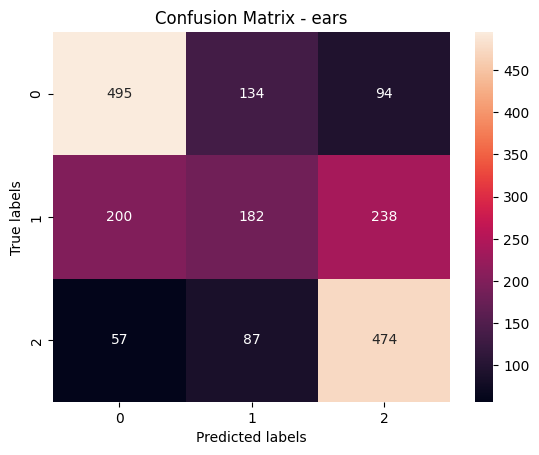

In [34]:
# make a confusion matrix
confusion = confusion_matrix(np.asarray(y_test).argmax(axis=1), np.asarray(y_pred).argmax(axis=1))
print('Confusion Matrix\n')
print(confusion)

lables = ['0','1','2']    
ax= plt.subplot()
sns.heatmap(confusion, annot=True, fmt='g', ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix - ears'); 
ax.xaxis.set_ticklabels(lables); ax.yaxis.set_ticklabels(lables);
plt.show()

In [35]:
!zip -r model_3.zip model_3

  adding: model_3/ (stored 0%)
  adding: model_3/assets/ (stored 0%)
  adding: model_3/keras_metadata.pb (deflated 96%)
  adding: model_3/fingerprint.pb (stored 0%)
  adding: model_3/variables/ (stored 0%)
  adding: model_3/variables/variables.data-00000-of-00001 (deflated 22%)
  adding: model_3/variables/variables.index (deflated 69%)
  adding: model_3/saved_model.pb (deflated 90%)
